In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
#import sys, h5py, binascii

import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh
#from pygimli.meshtools.mesh import exportHDF5Mesh
#from pygimli.meshtools import convertMesh

In [69]:
#Def des paramètres de géométrie du modéle
xmin,xmax = 0, 40 # en cm
emin,emax = 0, 80 #  elevation en cm
dtrou = 30 # prof du trou en cm
etrou = emax - dtrou # elevation du fond du trou
r=2 # rayon du trou en cm
dx = .1 #On définit le pas de la maille
zaff= 20 #profondeur en cm jusqu'où on souhaite un maillage affiné. 
eaff=etrou-zaff

assert dtrou + zaff < emax

xtrou_reg = np.arange(xmin, r + dx, dx, 'float')
etrou_reg = np.arange(etrou, emax + dx, dx, 'float')


efin_reg = np.arange(eaff, etrou + dx, dx, 'float')
h_0=-95 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1=10 #hauteur d'eau au fond du trou en cm

In [61]:
ztrou[len(ztrou)-2:0:-1]

array([ 79.8,  79.7,  79.6,  79.5,  79.4,  79.3,  79.2,  79.1,  79. ,
        78.9,  78.8,  78.7,  78.6,  78.5,  78.4,  78.3,  78.2,  78.1,
        78. ,  77.9,  77.8,  77.7,  77.6,  77.5,  77.4,  77.3,  77.2,
        77.1,  77. ,  76.9,  76.8,  76.7,  76.6,  76.5,  76.4,  76.3,
        76.2,  76.1,  76. ,  75.9,  75.8,  75.7,  75.6,  75.5,  75.4,
        75.3,  75.2,  75.1,  75. ,  74.9,  74.8,  74.7,  74.6,  74.5,
        74.4,  74.3,  74.2,  74.1,  74. ,  73.9,  73.8,  73.7,  73.6,
        73.5,  73.4,  73.3,  73.2,  73.1,  73. ,  72.9,  72.8,  72.7,
        72.6,  72.5,  72.4,  72.3,  72.2,  72.1,  72. ,  71.9,  71.8,
        71.7,  71.6,  71.5,  71.4,  71.3,  71.2,  71.1,  71. ,  70.9,
        70.8,  70.7,  70.6,  70.5,  70.4,  70.3,  70.2,  70.1,  70. ,
        69.9,  69.8,  69.7,  69.6,  69.5,  69.4,  69.3,  69.2,  69.1,
        69. ,  68.9,  68.8,  68.7,  68.6,  68.5,  68.4,  68.3,  68.2,
        68.1,  68. ,  67.9,  67.8,  67.7,  67.6,  67.5,  67.4,  67.3,
        67.2,  67.1,

In [70]:
#A présent on crée une zone grâce à un polygone

poly = pg.Mesh(2)  # empty 2d mesh
nStart = poly.createNode(r, emax, 0.0) #On crée un noeud de départ, on travaille en 2D donc le dernier terme vaut 0.0

nA = nStart #On définit le noeud de départ
for e in etrou_reg[len(etrou_reg)-2:0:-1]: #On démarre du haut et on se balade sur l'axe des z en créant un noeud à chaque fois
    nB = poly.createNode(r, e, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée

nB = poly.createNode(r, etrou, 0.0) #On crée un noeud    
poly.createEdge(nA, nB)
nA = nB
    
for x in xtrou_reg[len(xtrou_reg)-2:0:-1]:
    nB = poly.createNode(x, etrou, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nB = poly.createNode(0, etrou, 0.0) #On crée un noeud    
poly.createEdge(nA, nB)
nA = nB

for e in efin_reg[len(efin_reg)-2:0:-1]: #On démarre de 1 et on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly.createNode(0, e, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nC = poly.createNode(0.0, 0.0, 0.0)
poly.createEdge(nB, nC)
nD = poly.createNode(xmax, 0.0, 0.0)
poly.createEdge(nC, nD)
nE = poly.createNode(xmax, emax, 0.0)
poly.createEdge(nD, nE)
poly.createEdge(nE, nStart) #On ferme le polygone!

tri = pg.TriangleWrapper(poly) #On appelle la fonction triangle
tri.setSwitches('-pzeAfaq31')
# Ici on a :
# p : planar straight line graph ==> fichier poly
# z : on démarre le comptage à 0
# A : assigne un attribut à chaque triangle qui indique à quel segment il appartient et est lié
# f : algorithme de triangulation (?)
# a : impose une surface contrainte pour chaque triangle on peut ajouter un nombre si on veut préciser
# q31 : impose que les triangles générés aient au minimun des angles de 20° On peut ajouter un nombre derrière pour préciser le nombre que l'o souhaite

In [71]:
#A présent on génère le maillage hétérogène

mesh = pg.Mesh(2) #On appelle le second maillage autour du premier
tri.generate(mesh) #On génère les triangles au sein du polygone précédemment crée

In [72]:
for cell in mesh.cells(): #On génère les cellules de chaque maille
    cell.setMarker(2)
    

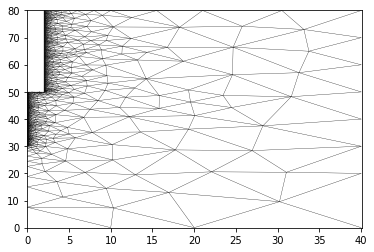

(<matplotlib.axes._subplots.AxesSubplot at 0x7f57a3a6e908>, None)

In [73]:
showMesh(mesh)

In [75]:
pg_pos = mesh.positions()
mesh_pos = np.array((np.array(pg.x(pg_pos)), np.array(pg.y(pg_pos)), np.array(pg.z(pg_pos)))).T
mesh_cells = np.zeros((mesh.cellCount(), 3))
for i, cell in enumerate(mesh.cells()):
        mesh_cells[i] = cell.ids()

In [76]:
print(mesh_pos.shape)
print(mesh_pos)

(1868, 3)
[[  2.          80.           0.        ]
 [  2.          79.9          0.        ]
 [  2.          79.8          0.        ]
 ..., 
 [ 26.93308895  28.38929294   0.        ]
 [ 31.0366071   20.4098489    0.        ]
 [ 40.          30.           0.        ]]


In [78]:
mesh.boundaries() #utiliser la tabulation pour lister les operations possibles sur un objet. mesh.'tab par exemple

mesh.cellCount()
mesh.nodeCount()

1868

In [32]:
a=np.array([1,2])
np.cross(a,a)

array(0)

In [45]:
for c in mesh.cells():
    print([[node.x(),node.y()] for node in c.nodes()])
    

[[0.010753377629, -0.285], [0.0, -0.29], [0.008863965212, -0.295]]
[[0.150177441689, -0.633557928406], [0.179813355773, -0.432295126134], [0.051680360248, -0.471568379339]]
[[0.051680360248, -0.471568379339], [-0.02, -0.425], [-0.02, -0.55]]
[[0.012995955939, -0.312682152341], [0.0, -0.3], [-0.005421352026, -0.318555334704]]
[[-0.005421352026, -0.318555334704], [-0.02, -0.33125], [0.006422196202, -0.346875]]
[[0.017127946667, -0.245], [0.037970645029, -0.248277120034], [0.041354972884, -0.227451560841]]
[[0.010753377629, -0.205], [0.0, -0.19999999999999998], [0.0, -0.21]]
[[0.0, -0.27999999999999997], [0.0, -0.29], [0.010753377629, -0.285]]
[[0.0, -0.09999999999999999], [0.0, -0.11], [0.017127946667, -0.105]]
[[0.008863965212, -0.265], [0.010753377629, -0.255], [0.0, -0.26]]
[[0.0, -0.27], [0.0, -0.27999999999999997], [0.017127946667, -0.275]]
[[0.047297333058999996, -0.155474960878], [0.070229495442, -0.158939476962], [0.07519653643, -0.136285218045]]
[[0.0, -0.27999999999999997], [0.

In [79]:
#c=mesh.cell(0) renvoie la cellule 0

def crossprod(c):

    node0=c.node(0)
    a0=np.array([node0.x(),node0.y()])
    node1=c.node(1)
    a1=np.array([node1.x(),node1.y()])
    node2=c.node(2)
    a2=np.array([node2.x(),node2.y()])

    #faire un produit vectoriel entre node[1]-node[0] et node[2]-node[0]. 
    return np.cross(a1-a0,a2-a0)

crossprod(mesh.cell(0))
# si négatif, node[1],node[2]=node[2],node[1]
# afficher node[0] node[1] node[2]
#c.boundaryNodes

array(0.021433447398304162)

In [80]:
f=open("maillage.txt","w")

for c in mesh.cells(): 
    assert crossprod(c) > 0 # arrete tout si c'est faux.
    for node in c.nodes():
        #f.write(str([[node.x(),node.y()]]))
        f.write("{} {} \n".format(node.x(),node.y()))
f.close()
    

In [81]:
!cat maillage.txt

0.171279466666 38.85 
0.107533776285 38.75 
0.269366180869 38.667638244899 
10.320657517587 7.262917247301 
20.0 0.0 
16.950923213359 12.9643473551 
0.171279466666 38.85 
0.296477610624 38.924497154741 
0.183174431626 39.016076578978996 
0.0 30.2 
0.107533776285 30.25 
0.0 30.3 
0.0 30.2 
0.0 30.099999999999998 
0.171279466666 30.15 
0.0 39.199999999999996 
0.171279466666 39.25 
0.0 39.3 
0.107533776285 38.449999999999996 
0.0 38.5 
0.0 38.4 
0.171279466666 30.45 
0.0 30.5 
0.0 30.4 
0.322002933822 38.337432049158 
0.171279466666 38.35 
0.222517679611 38.223510141104 
0.0 30.599999999999998 
0.0 30.5 
0.107533776285 30.55 
0.0 30.5 
0.171279466666 30.45 
0.107533776285 30.55 
0.107533776285 38.449999999999996 
0.0 38.4 
0.171279466666 38.35 
0.0 30.3 
0.107533776285 30.25 
0.08863965212 30.349999999999998 
0.107533776285 39.15 
0.171279466666 39.25 
0.0 39.199999999999996 
0.222517679611 38.223510141104 
0.107533776285 38.15 
0.171279466666 38.05 
0.107533776285 30.849999999999998 
0.0

2.107533776285 74.95 
0.0 31.5 
0.0 31.4 
0.107533776285 31.45 
0.171279466666 33.75 
0.107533776285 33.65 
0.269366180869 33.567638244899 
2.0 76.7 
2.107533776285 76.75 
2.0 76.8 
0.171279466666 33.35 
0.0 33.3 
0.107533776285 33.25 
2.107533776285 77.25 
2.171279466666 77.35 
2.0 77.3 
2.0 76.8 
2.107533776285 76.75 
2.08863965212 76.85 
0.171279466666 33.15 
0.171279466666 33.35 
0.107533776285 33.25 
0.0 33.0 
0.08863965212 32.95 
0.107533776285 33.05 
2.0 77.3 
2.0 77.2 
2.107533776285 77.25 
0.0 36.699999999999996 
0.08863965212 36.65 
0.107533776285 36.75 
2.0 77.39999999999999 
2.171279466666 77.35 
2.107533776285 77.45 
2.184934674056 77.098040628916 
2.107533776285 77.25 
2.08863965212 77.14999999999999 
0.107533776285 36.05 
0.171279466666 36.15 
0.0 36.1 
2.08863965212 77.14999999999999 
2.0 77.2 
2.0 77.1 
0.0 32.9 
0.086625948775 32.85 
0.08863965212 32.95 
0.222517679611 35.723510141104 
0.171279466666 35.85 
0.08863965212 35.75 
2.0 77.5 
2.171279466666 77.55 
2.0 77.6

3.001943569417 62.1605540858 
3.201142034009 61.229318039538 
3.998631378531 61.892424716979995 
3.001943569417 62.1605540858 
2.710993344486 61.403378507689 
3.201142034009 61.229318039538 
3.001943569417 67.66055408579899 
3.0047882798959997 68.149570965626 
2.706126187647 68.002668969913 
2.995754569843 68.482283504875 
3.0047882798959997 68.149570965626 
3.570139687627 68.331400125649 
0.413549728842 47.425484391586 
0.786540591706 47.394061508816 
0.740301813864 47.765506735956 
1.268745522705 48.478835245088 
1.713332790136 48.837914066496 
1.352960824928 49.103295979239 
1.985036826807 48.046739935779 
1.268745522705 48.478835245088 
1.270988367043 47.610948258751 
3.498666403164 49.696231861232 
3.744936099691 50.480362343306 
3.234298013062 50.247072496029 
0.793427083853 48.315028722473 
0.9067986397259999 48.026739532248996 
1.268745522705 48.478835245088 
0.9067986397259999 48.026739532248996 
0.740301813864 47.765506735956 
1.270988367043 47.610948258751 
0.898666566855 35

In [1]:
pg.x?

Object `pg.x` not found.


In [ ]:
l=list(pg_pos)

In [ ]:
l[1]

In [ ]:
list(l[1])

In [ ]:
mesh.saveAscii('mesh.a')
